Examples of how to use the BCES fitting code
===================

BCES python module [available on Github](https://github.com/rsnemmen/BCES).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cd '/Users/nemmen/Dropbox/codes/python/bces/doc'

/Users/nemmen/Dropbox/codes/python/bces/doc


In [3]:
import bces.bces as BCES

# Example 1

In this example, the data contains uncertainties on both $x$ and $y$; no correlation between uncertainties. These are real astronomical data for blazars from [this paper](http://science.sciencemag.org/content/338/6113/1445.full). 

In [5]:
data=np.load('data.npz')
xdata=data['x']
ydata=data['y']
errx=data['errx']
erry=data['erry']
cov=data['cov']

The regression line is $y = Ax + B$. `covab` is the resulting covariance matrix which can be used to draw confidence regions.

In [6]:
# number of bootstrapping trials
nboot=10000

In [7]:
%%time
# Performs the BCES fit in parallel
a,b,erra,errb,covab=BCES.bcesp(xdata,errx,ydata,erry,cov,nboot)

BCES, 10000 trials... 
1.401265 s
CPU times: user 34.4 ms, sys: 60.3 ms, total: 94.7 ms
Wall time: 1.42 s


## Selecting the fitting method

Select the desired BCES method by setting the variable `bcesMethod`. The available methods are:

| Value  | Method  |  Description |
|---|---| --- |
| 0  | $y|x$  | Assumes $x$ as the independent variable |
| 1  |  $x|y$ | Assumes $y$ as the independent variable |
| 2  | bissector  | Line that bisects the $y|x$ and $x|y$. *Do not use this method*, cf. [Hogg, D. et al. 2010, arXiv:1008.4686](http://labs.adsabs.harvard.edu/adsabs/abs/2010arXiv1008.4686H/). |
| 3  | orthogonal  | Orthogonal least squares: line that minimizes orthogonal distances. Should be used when it is not clear which variable should be treated as the independent one |

As usual, please read the [original BCES paper](http://labs.adsabs.harvard.edu/adsabs/abs/1996ApJ...470..706A/) to understand what these different lines mean.

In [8]:
bcesMethod=0

Text(0, 0.5, '$y$')

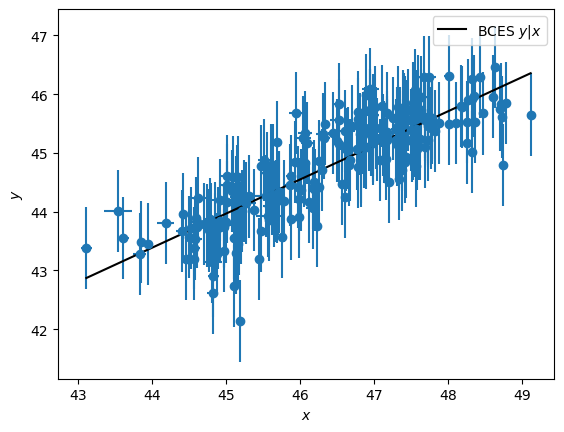

In [10]:
plt.errorbar(xdata,ydata,xerr=errx,yerr=erry,fmt='o')
x=np.linspace(xdata.min(),xdata.max())
plt.plot(x,a[bcesMethod]*x+b[bcesMethod],'-k',label="BCES $y|x$")

plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')

## Confidence band

Suppose you want to include in the plot a visual estimate of the uncertainty on the fit. This is called the confidence band. For example, the $3\sigma$ confidence interval is 99.7% sure to contain the best-fit regression line. Note that this is *not* the same as saying it will contain 99.7% of the data points. For more information, [check this out](http://www.jerrydallal.com/LHSP/slr.htm).

In order to plot the confidence band, you will need to [install the `nmmn` package](https://github.com/rsnemmen/nmmn#installation) and another dependency: 

    pip install nmmn numdifftools

After installing the package, follow the instructions below to plot the confidence band of your fit.

First we define convenient arrays that encapsulate the fit parameters and their uncertainties—including the covariance.

In [11]:
# array with best-fit parameters
fitm=np.array([ a[bcesMethod],b[bcesMethod] ])	
# covariance matrix of parameter uncertainties
covm=np.array([ (erra[bcesMethod]**2,covab[bcesMethod]), (covab[bcesMethod],errb[bcesMethod]**2) ])	

# convenient function for a line
def func(x): return x[1]*x[0]+x[2]

Now we estimate the $3\sigma$ confidence band using one of the methods in the `nmmn.stats` module. If you want the $1\sigma$ band instead, just change the 7th argument of `confbandnl` to `0.68`.

In [12]:
import nmmn.stats

# Gets lower and upper bounds on the confidence band 
lcb,ucb,x=nmmn.stats.confbandnl(xdata,ydata,func,fitm,covm,2,0.997,x)

Finally, the plot with the confidence band displayed in orange. Even at $3\sigma$, it is still very narrow for this dataset.

Text(0.5, 1.0, 'Data, fit and confidence band')

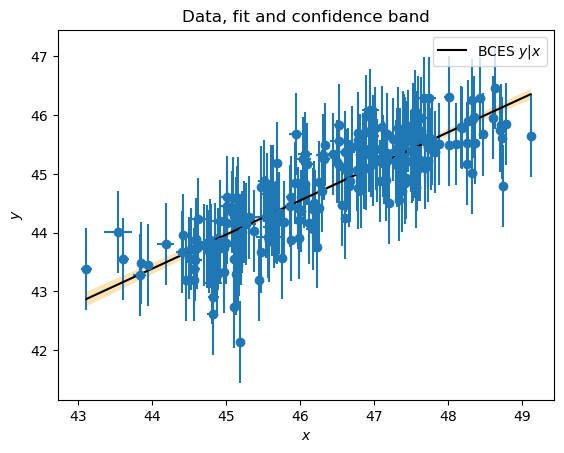

In [13]:
plt.errorbar(xdata,ydata,xerr=errx,yerr=erry,fmt='o')
plt.plot(x,a[bcesMethod]*x+b[bcesMethod],'-k',label="BCES $y|x$")
plt.fill_between(x, lcb, ucb, alpha=0.3, facecolor='orange')

plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Data, fit and confidence band")

# Example 2

Fake data with random uncertainties in $x$ and $y$

Prepares fake data

In [14]:
x=np.arange(1,20)
y=3*x + 4

xer=np.sqrt((x- np.random.normal(x))**2)
yer=np.sqrt((y- np.random.normal(y))**2)

y=np.random.normal(y)
x=np.random.normal(x)

In [15]:
# simple linear regression
(aa,bb)=np.polyfit(x,y,deg=1)
yfit=x*aa+bb

In [16]:
# BCES fit
cov=np.zeros(len(x))   # no correlation between error measurements
nboot=10000   # number of bootstrapping trials
a,b,aerr,berr,covab=BCES.bcesp(x,xer,y,yer,cov,nboot)

BCES, 10000 trials... 
1.311906 s


The integer corresponds to the desired BCES method for plotting (3-ort, 0-y|x, 1-x|y, *don't use bissector*)

In [17]:
bcesMethod=3
ybces=a[bcesMethod]*x+b[bcesMethod]

Text(0, 0.5, '$y$')

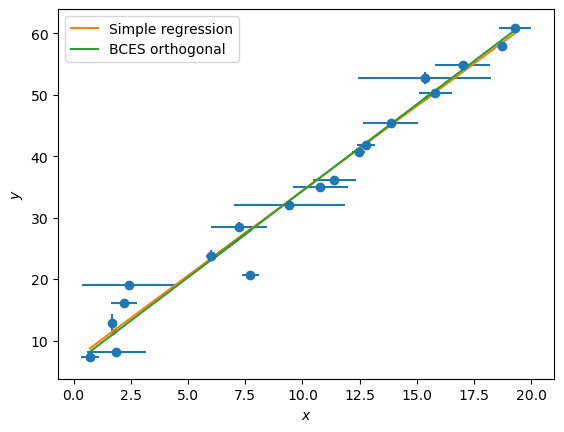

In [18]:
plt.errorbar(x,y,xer,yer,fmt='o',ls='None')
plt.plot(x,yfit,label='Simple regression')
plt.plot(x,ybces,label='BCES orthogonal')

plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')

## Confidence band

Again, make sure you install the [`nmmn`](https://github.com/rsnemmen/nmmn#installation) package before proceeding.

In [21]:
# array with best-fit parameters
fitm=np.array([ a[bcesMethod],b[bcesMethod] ])	
# covariance matrix of parameter uncertainties
covm=np.array([ (aerr[bcesMethod]**2,covab[bcesMethod]), (covab[bcesMethod],berr[bcesMethod]**2) ])	

Now we estimate the $2\sigma$ confidence band using one of the methods in the `nmmn.stats` module.

In [22]:
# Gets lower and upper bounds on the confidence band 
lcb,ucb,xcb=nmmn.stats.confbandnl(x,y,func,fitm,covm,2,0.954,x)

Finally, the plot where the confidence band is displayed in orange. As you can see, it is very narrow.

Text(0.5, 1.0, 'Data, fit and confidence band')

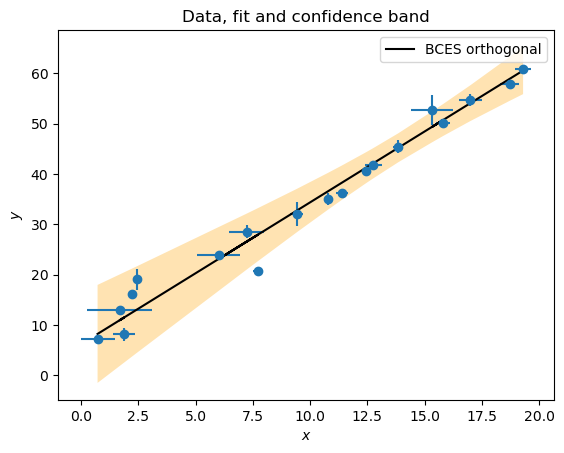

In [23]:
plt.errorbar(x,y,xerr=xer,yerr=yer,fmt='o')
plt.plot(xcb,a[bcesMethod]*xcb+b[bcesMethod],'-k',label="BCES orthogonal")
plt.fill_between(xcb, lcb, ucb, alpha=0.3, facecolor='orange')

plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Data, fit and confidence band")